In [125]:
%matplotlib inline
from helper import *
import plotter as pltr

In [126]:
# Hyper-parameters
window_size = 50
step_size = int(0.1 * window_size)
dataset = 'SMD'

## Step 1. Load Dataset

In [127]:
if dataset == 'SMD':
    GROUP = 1
    ENTITY = 2
    SMD_BASE_PATH = 'Dataset/SMD'

    X_train = load_data('%s/train/machine-%d-%d.txt' % (SMD_BASE_PATH, GROUP, ENTITY), header=False)
    X_train.columns = ['m%d' % i for i in range(X_train.shape[1])]
    X_train.index = pd.date_range('2021/03/02', '2021/03/21', periods=X_train.shape[0])
    X_train.index.name = 'timestamp'

    X_test = load_data('%s/test/machine-%d-%d.txt' % (SMD_BASE_PATH, GROUP, ENTITY), header=False)
    X_test.columns = ['m%d' % i for i in range(X_test.shape[1])]
    X_test.index = pd.date_range('2021/03/21', '2021/4/8', periods=X_test.shape[0])
    X_test.index.name = 'timestamp'

    y_true = pd.read_csv('Dataset/SMD/test_label/machine-%d-%d.txt' % (GROUP, ENTITY), header=None)
    y_true.columns = ['label']
    y_true.index = X_test.index

In [128]:
print('Train Shape:', X_train.shape)
print('Test Shape:', X_test.shape)

Train Shape: (23694, 37)
Test Shape: (23694, 37)


In [129]:
# plot the first dimension
# pltr.plot_data(pd.concat([X_train, X_test], axis=0), 'm0')

In [130]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [131]:
# X_train = X_train.to_numpy()

In [132]:
# plt.plot(np.arange(X_train.shape[0]), X_train[:, 2])

## Step 2. Anomaly Detection

In [133]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt
import arviz as az

pm.set_tt_rng(42)
np.random.seed(42)

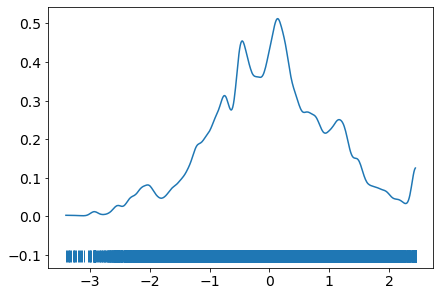

In [134]:
az.plot_kde(X_train[:, 4], rug=True)
plt.show()

In [135]:
with pm.Model() as model:
    pm.Normal('N', mu=0, sigma=1, shape=(X_train.shape[1], ))  # base distribution
    inference = pm.NFVI(flow="planar*4", jitter=0.01, observed=X_train)
    approx = inference.fit(
        n=10000,
        score=True,
        obj_optimizer=pm.adam(learning_rate=0.01),
        obj_n_mc=100,
        callbacks=[pm.callbacks.CheckParametersConvergence()],
        progressbar=True,
    )

Finished [100%]: Average Loss = 0.032381


In [136]:
# params
inference.approx.shared_params

{0: {'u': u, 'w': w, 'b': b},
 1: {'u': u, 'w': w, 'b': b},
 2: {'u': u, 'w': w, 'b': b},
 3: {'u': u, 'w': w, 'b': b}}

In [137]:
# optimizer
inference.objective.op

In [138]:
# approximation
approx.input.tag.trace

[[('/home/ubuntu/.local/lib/python3.8/site-packages/pymc3/variational/approximations.py',
   612,
   '__init__',
   'super().__init__(*args, **kwargs)'),
  ('/home/ubuntu/.local/lib/python3.8/site-packages/pymc3/variational/approximations.py',
   539,
   '__init__',
   'super().__init__(groups, model=kwargs.get("model"))'),
  ('/home/ubuntu/.local/lib/python3.8/site-packages/pymc3/variational/opvi.py',
   1308,
   '__init__',
   'rest.__init_group__(list(set(model.free_RVs) - seen))'),
  ('/home/ubuntu/.local/lib/python3.8/site-packages/theano/configparser.py',
   48,
   'res',
   'return f(*args, **kwargs)'),
  ('/home/ubuntu/.local/lib/python3.8/site-packages/pymc3/variational/approximations.py',
   375,
   '__init_group__',
   'super().__init_group__(group)'),
  ('/home/ubuntu/.local/lib/python3.8/site-packages/theano/configparser.py',
   48,
   'res',
   'return f(*args, **kwargs)'),
  ('/home/ubuntu/.local/lib/python3.8/site-packages/pymc3/variational/opvi.py',
   951,
   '__init_

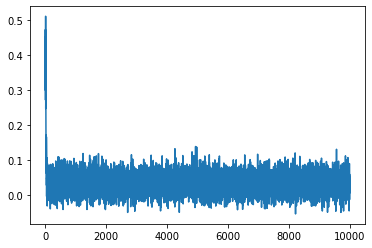

In [139]:
# approximation history(loss)
plt.plot(approx.hist)

In [ ]:
# https://github.com/pymc-devs/pymc3/blob/25eaa715018ed7add3ba1289b6ad068636e29e5e/pymc3/variational/opvi.py#L365
# step_fn = aesara.function([], updates.loss, updates=updates, **fn_kwargs)

In [182]:
inference.approx.input.all

<bound method _tensor_py_operators.all of NormalizingFlowGroup_symbolic_input>

(array([5.000e+00, 1.100e+01, 2.500e+01, 4.900e+01, 1.080e+02, 1.750e+02,
        3.110e+02, 5.220e+02, 8.130e+02, 1.185e+03, 1.728e+03, 2.375e+03,
        3.120e+03, 3.936e+03, 4.819e+03, 5.640e+03, 6.508e+03, 7.278e+03,
        7.955e+03, 8.488e+03, 8.933e+03, 9.242e+03, 9.485e+03, 9.653e+03,
        9.779e+03, 9.854e+03, 9.895e+03, 9.928e+03, 9.942e+03, 9.958e+03,
        9.962e+03, 9.967e+03, 9.970e+03, 9.972e+03, 9.974e+03, 9.974e+03,
        9.975e+03, 9.975e+03, 9.976e+03, 9.977e+03, 9.977e+03, 9.977e+03,
        9.977e+03, 9.977e+03, 9.977e+03, 9.977e+03, 9.977e+03, 9.977e+03,
        9.977e+03, 9.978e+03, 9.979e+03, 9.979e+03, 9.979e+03, 9.980e+03,
        9.980e+03, 9.980e+03, 9.980e+03, 9.983e+03, 9.984e+03, 9.984e+03,
        9.985e+03, 9.985e+03, 9.986e+03, 9.986e+03, 9.987e+03, 9.987e+03,
        9.987e+03, 9.987e+03, 9.987e+03, 9.987e+03, 9.987e+03, 9.988e+03,
        9.988e+03, 9.989e+03, 9.989e+03, 9.990e+03, 9.991e+03, 9.991e+03,
        9.992e+03, 9.992e+03, 9.993e+0

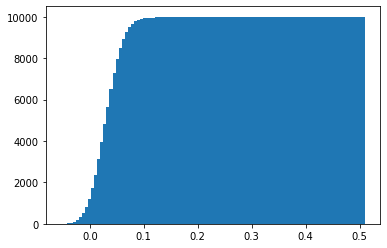

In [140]:
loss_hist = approx.hist
plt.hist(loss_hist, bins=100, cumulative=True)

In [151]:
traceNF = approx.sample(1000)
dftrace = pm.trace_to_dataframe(traceNF)

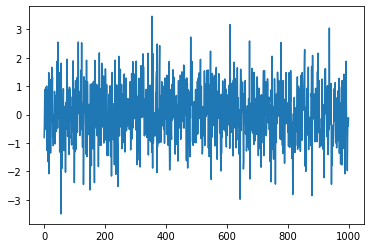

In [152]:
plt.plot(dftrace['N__1'])

In [154]:
with model:
    trace = pm.sample(1000, return_inferencedata=True)
    # idata = az.from_pymc3(trace)
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [N]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Inference data with groups:
	> posterior
	> sample_stats

/home/ubuntu/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


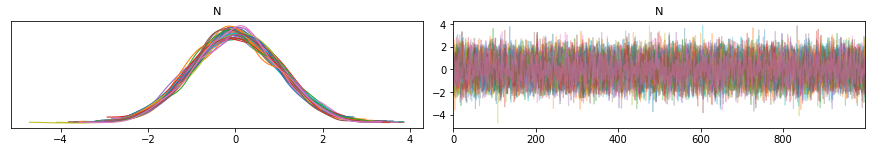

In [145]:
az.plot_trace(traceNF)
plt.show()

/home/ubuntu/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


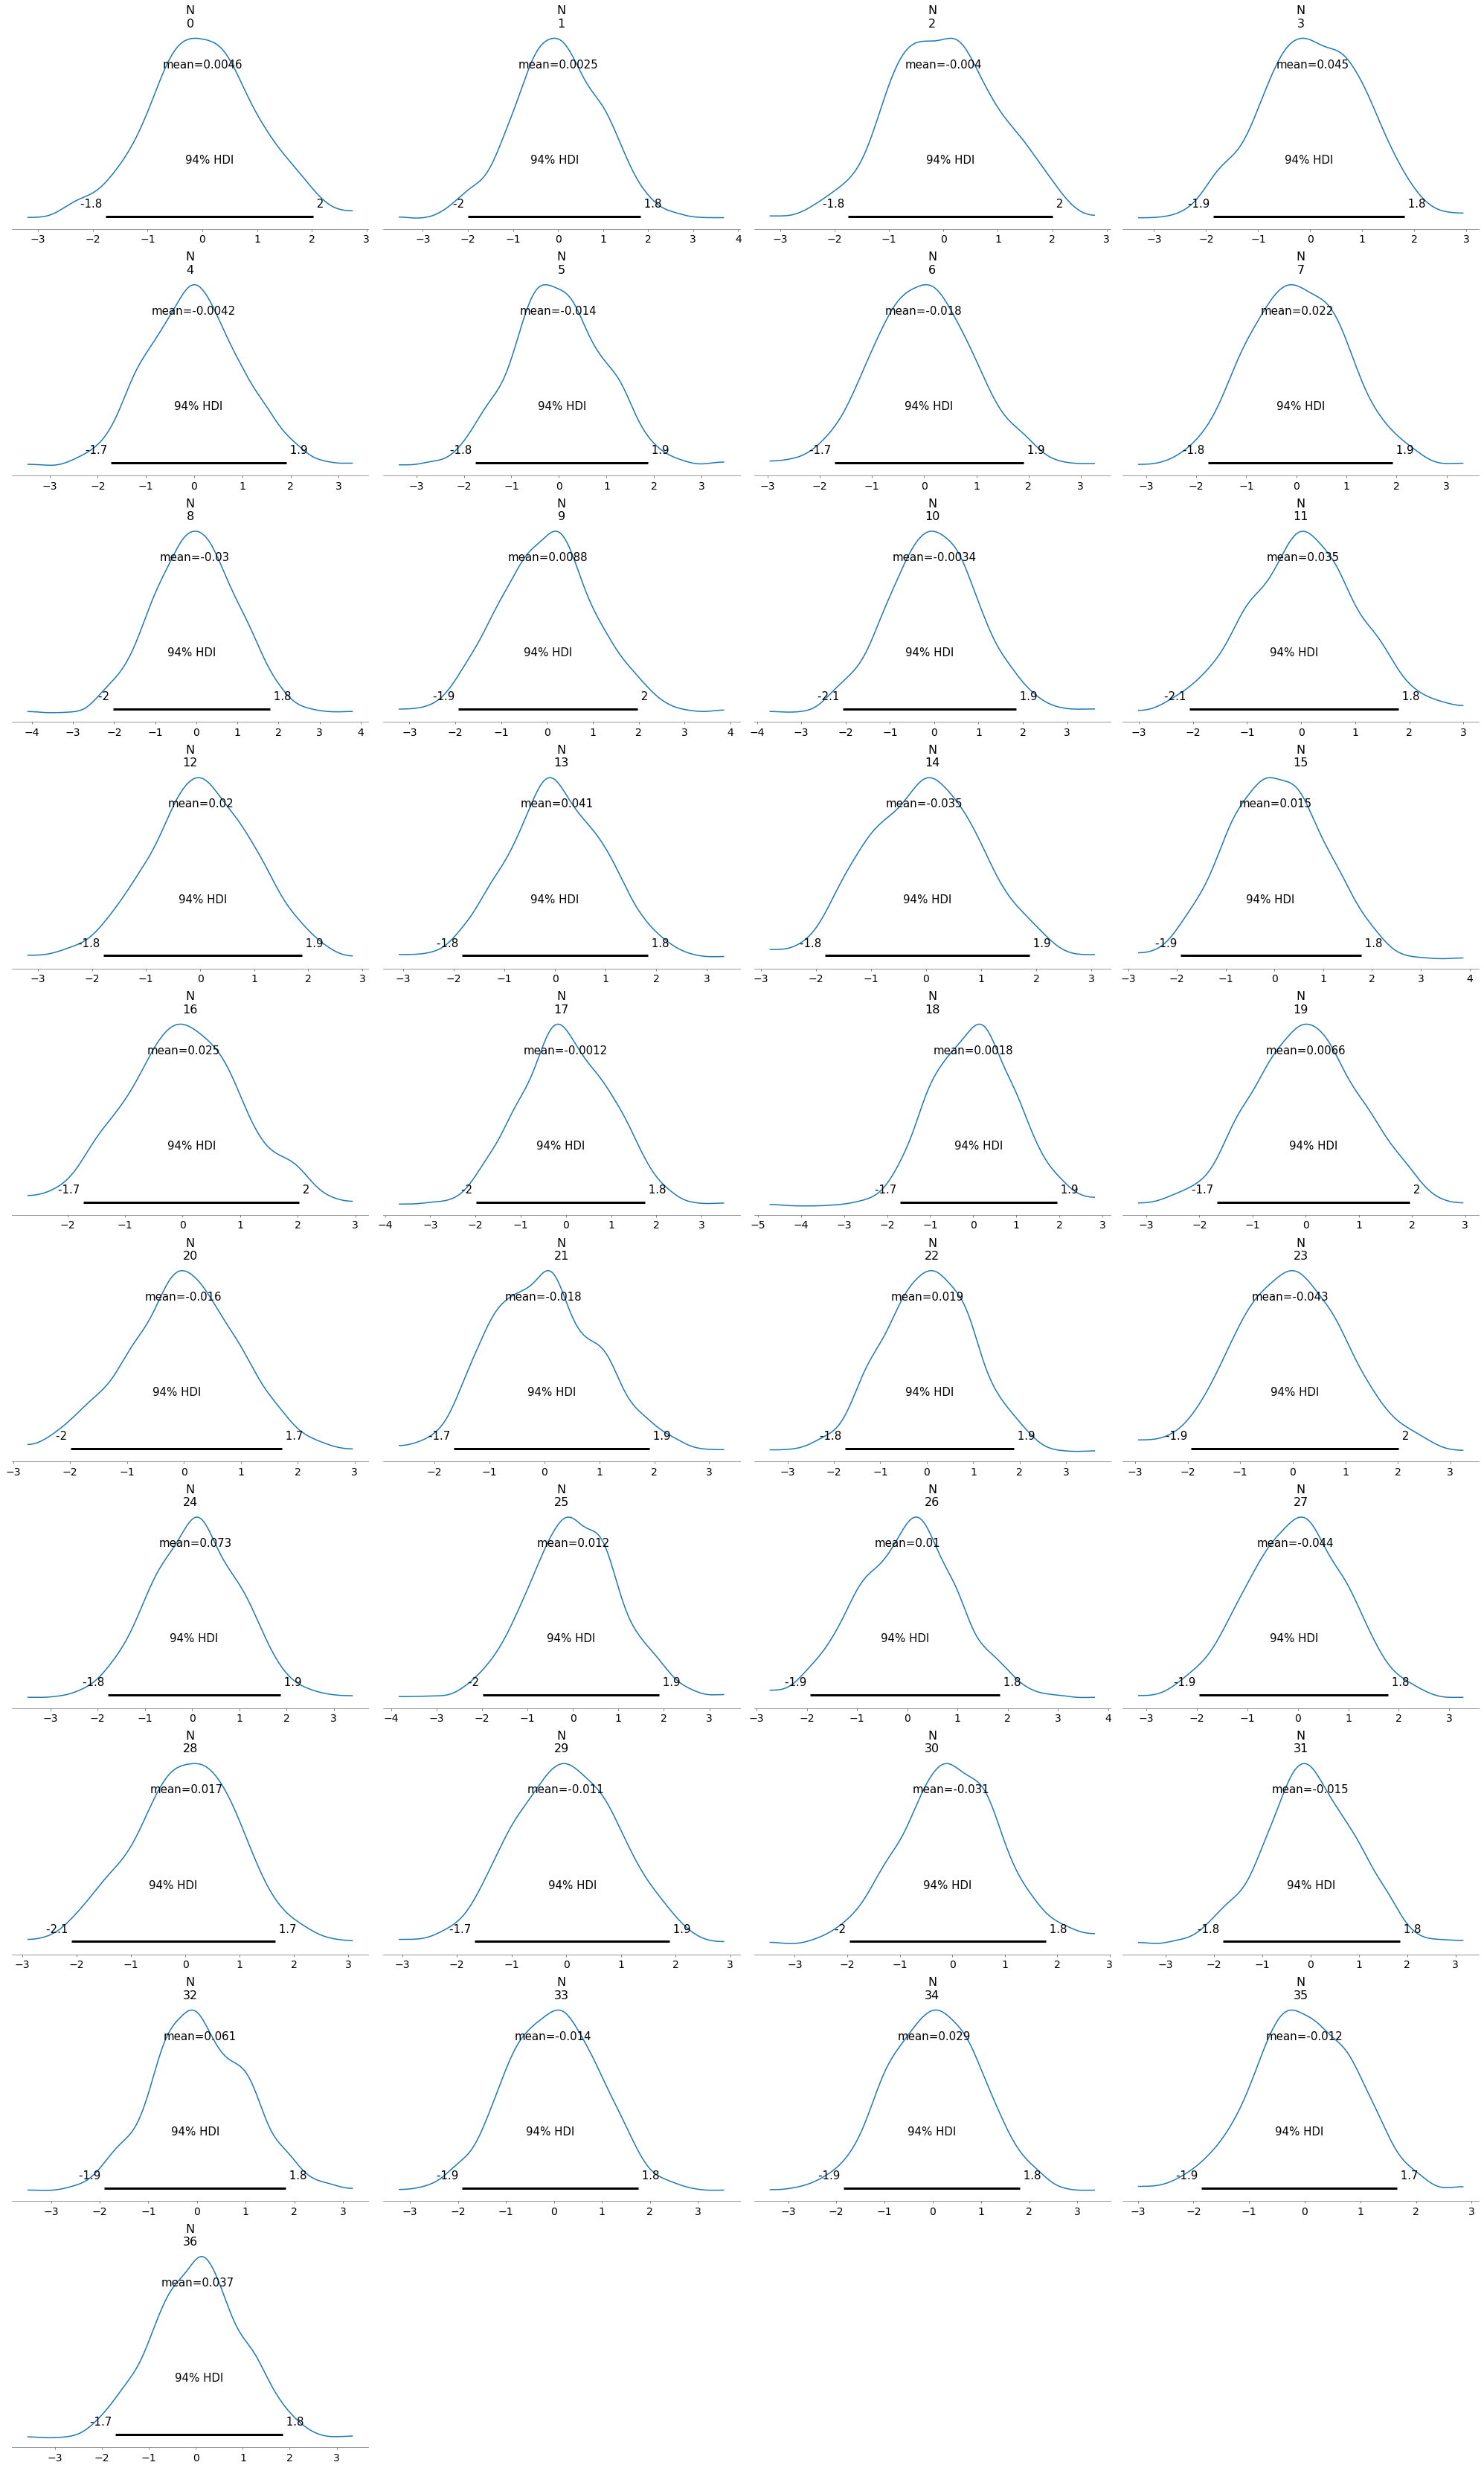

In [146]:
az.plot_posterior(traceNF)
plt.show()